# Load and pre-process data

## What's PCA
对一个nxn的对称矩阵进行分解，求出它的特征值和特征向量 产生n个n维的正交基，每个正交基会对应一个特征值。
把矩阵投影到这N个基上，此时特征值的模就表示矩阵在该基的投影长度。特征值越大，说明矩阵在对应的特征向量上的方差越大，样本点越离散，越容易区分，信息量也就越多。因此，特征值最大的对应的特征向量方向上所包含的信息量就越多，如果某几个特征值很小，那么就说明在该方向的信息量非常少，我们就可以删除小特征值对应方向的数据，只保留大特征值方向对应的数据，这样做以后数据量减小，但有用的信息量都保留下来了。

PCA的工作就是从原始的空间中顺序地找一组相互正交的坐标轴，新的坐标轴的选择与数据本身是密切相关的。其中，第一个新坐标轴选择是原始数据中方差最大的方向，第二个新坐标轴选取是与第一个坐标轴正交的平面中使得方差最大的，第三个轴是与第1,2个轴正交的平面中方差最大的。
最后只保留包含绝大部分方差的维度特征，而忽略包含方差几乎为0的特征维度，实现对数据特征的降维处理。

将一组N维向量降为K维（K大于0，小于N），其目标是选择K个单位正交基，使得原始数据变换到这组基上后，各字段两两间协方差为0，而字段的方差则尽可能大

解释

(1)最大方差理论；(2)最小化降维造成的损失
在信号处理中认为信号具有较大的方差，噪声有较小的方差，信噪比就是信号与噪声的方差比，越大越好。

## How to
计算数据矩阵的协方差矩阵，然后得到协方差矩阵的特征值特征向量，选择**特征值最大(即方差最大)的k个特征所对应的特征向量**组成的矩阵

得到协方差矩阵的特征值特征向量有两种方法:
1. 特征值分解协方差矩阵
2. 奇异值分解协方差矩阵, SVD(Singular Value Decomposition)

设有n条m维数据
1. 将原始数据按列组成m行n列矩阵X
2. 将X的每一行(代表一个属性字段）进行零均值化
3. 求出协方差矩阵 
4. 求出协方差矩阵的特征值及对应的特征向量
5. 将特征相浪按对应特征值大小从上到下按行排列成矩阵，取前k行组成矩阵P
6. Y=PX即为降维到k维后的数据

## Calculate PCA
对角化协方差矩阵
1. Calculating the covariance matrix;
2. Taking the eivenvectors & eigenvalues of this cov matrix


特征值 => PCA

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import random
from os import listdir
from PIL import Image
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

# Infrastructure code for dataset building  

In [2]:
class Subject:
    
    def __init__(self):
        self.label_image_dict= {}
    
    def add(self, image, label):
        self.label_image_dict[label] = image
    
    def get(self, label):
        return self.label_image_dict[label]

class Dataset:
    
    def __init__(self, data=[], labels=[]):
        self.data = []
        self.labels = []
    
    def to_numpy_array(self):
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        
    def insert(self, datum, label):
        self.data.append(datum)
        self.labels.append(label)
    
    def extend(self, data, labels):
        self.data.extend(data)
        self.labels.extend(labels)
    
    def shuffle(self):
        idx = np.array(list(range(len(self.data))))
        np.random.shuffle(idx)
        self.data[:] = self.data[idx]
        self.labels[:] = self.labels[idx]
    
class DataBuilder:
    
    def __init__(self):
        self.subjects = defaultdict(Subject)
    
    def get_subject_ids(self):
        return list(self.subjects.keys())
    
    def load_data(self, data_dir="./CAFE/"):
        # Get the list of image file names
        all_files = listdir(data_dir)
        
        # Store the images and labels in self.subjects dictionary
        for file in all_files:
            # Load in the files as PIL images and convert to NumPy arrays
            subject, rest_string = file.split('_')
            label = rest_string.split('.')[0][:-1]
            
            # Exclude neutral and happy faces 
            if label != 'n' and label != 'h':
                img = Image.open(data_dir + file)
                self.subjects[subject].add(np.array(img, dtype=np.float64).reshape(-1, ), label) # Reshaped to a vector        
        
    def build_dataset(self, test_subject_id, labels):
        train, holdout, test, pca = Dataset(), Dataset(), Dataset(), []
        
        # Select data for train, holdout and test dataset
        subject_ids = self.get_subject_ids()
        test_subject = self.subjects[test_subject_id]
        subject_ids.remove(test_subject_id)
        
        holdout_subject_id = random.choice(subject_ids)
        holdout_subject = self.subjects[holdout_subject_id]
        subject_ids.remove(holdout_subject_id)
        
        for label in labels:
            test.insert(test_subject.get(label), label)
            holdout.insert(holdout_subject.get(label), label)
            train.extend([self.subjects[train_subject_id].get(label) for train_subject_id in subject_ids], [label] * len(subject_ids))
            
        # Select data for PCA
        for train_subject_id in subject_ids:
            pca.extend(list(self.subjects[train_subject_id].label_image_dict.values()))
        
        # To numpy array
        train.to_numpy_array()
        holdout.to_numpy_array()
        test.to_numpy_array()
        pca = np.array(pca)
        
        # Normalization
        mean = np.mean(pca, axis=0)
        standard_diviation = np.sqrt(np.sum(pca * pca, axis=0) / len(pca))
        pca_normalized = (pca - mean) / standard_diviation
        train.data = (train.data - mean) / standard_diviation
        holdout.data = (holdout.data - mean) / standard_diviation
        test.data = (test.data - mean) / standard_diviation
        
        return train, holdout, test, pca_normalized 

# Utilities for image display

In [3]:
def display_faces(images, labels):
    selected_faces = set()
    different_faces = []
    different_labels = []
    for img, label in zip(images, labels):
        if label not in selected_faces:
            different_faces.append(img)
            different_labels.append(label)
            selected_faces.add(label)
    for i in range(6):
        plt.subplot(2, 3, i + 1)  # 1-6
        plt.title(emotion_dict[different_labels[i]])
        display_face(different_faces[i])

def display_face(img):
    """ Display the input image and optionally save as a PNG.
    Args:
        img: The NumPy array or image to display
    Returns: None
    """
    img = img.reshape(380, 240)
    # Convert img to PIL Image object (if it's an ndarray)
    if type(img) == np.ndarray:
        img = Image.fromarray(img)

    # Display the image
#     img.show() # for python only
    plt.imshow(np.asarray(img), cmap='gray') # for jupyter notebook inline display
    
def display_eigs(eigen_vectors):
    fake_faces = eigen_vectors.T[0:6]
    for i in range(6):
        plt.subplot(2, 3, i + 1)  # 1-6
        plt.title("eigenface{}".format(i))
        display_face(fake_faces[i].reshape(380, 240))

In [4]:
class PCA:
    
    def __init__(self, data):
        """
        data is stored row wise
        """
        self.data = data
        self.sorted_idx, self.eig_val, self.eig_vec = self.__pca__(data)
    
    def __pca__(self, data):
        """
        returns: data transformed in 2 dims/columns + regenerated original data
        pass in: data as 2D NumPy array
        """ 
#         print("pca data={}".format(data.shape))
#         print(data.std(axis=0))
        # Subtract the mean
        data -= data.mean(axis=0)

        # Calculate covariance
        cov = np.cov(data)
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        
        # Sort eigenvalue in decreasing order
        sorted_idx = np.argsort(eig_vals)[::-1]
        
        # Map the eigenvectors to original ones
        eig_vecs = np.dot(data.T, eig_vecs)
        
        # Normalization
        eig_vecs = eig_vecs / np.sqrt(np.sum(eig_vecs * eig_vecs, axis=0)) 
        return sorted_idx, eig_vals, eig_vecs
    
    def transform(self, data, n_components):
        selected_idx = self.sorted_idx[:n_components]
        return np.dot(data, self.eig_vec[:, selected_idx])

# Display 6 different emotional faces

In [5]:
# display_faces(train.data, train.labels)

# 1(c) Display eigen face

In [6]:
# dims_rescaled_data = min(len(train_data) - 1, len(train_data[0]))
# from sklearn.decomposition import PCA

# pca = PCA(n_components=10)
# pca.fit(train.data)
# test = pca.transform(holdout.data)

# print(test[0])

# pca = PCA(train.data)
# train.data = pca.transform(train.data, 10)
# holdout.data = pca.transform(holdout.data, 10)
# test.data = pca.transform(test.data, 10)
# display_eigs(pca.eig_vec)

In [7]:
class LogisticClassifier:
    
    # data: row wise
    # labels: row wise
    def __init__(self):
        self.w = None
    
    def load_data(self, train, holdout, test):
        
        # Translate labels from strings to numerical values 
        train_labels = set(train.labels)
        holdout_labels = set(holdout.labels)
        assert(train_labels==holdout_labels)
        labels = list(train_labels)
        encode_dict_float = {labels[0]:0., labels[1]:1.}
        encode_dict_bool = {labels[0]:False, labels[1]:True}
        
        self.train_X = np.column_stack((np.ones(len(train.data)), train.data))
        self.train_y = self.__label_translation__(train.labels, encode_dict_float).reshape(-1, 1)
        
        self.holdout_X = np.column_stack((np.ones(len(holdout.data)), holdout.data))
        self.holdout_y = self.__label_translation__(holdout.labels, encode_dict_float).reshape(-1, 1)
        
        self.test_X = np.column_stack((np.ones(len(test.data)), test.data))
        self.test_y = self.__label_translation__(test.labels, encode_dict_bool).reshape(-1, 1)
    
    def __label_translation__(self, y, encode_dict):
        return np.array([encode_dict[label] for label in y]).T
    
    # return a predicted label
    def predict(self, X):
        return self.sigmoid(np.dot(X, self.w)) > 0.5
    
    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    
    def cross_entropy_loss(self, y, y_hat):
        return - np.dot(y.T, np.log(y_hat))
    
    def train_loss(self):
        train_y_hat = self.sigmoid(np.dot(self.train_X, self.w))
        return self.cross_entropy_loss(self.train_y, train_y_hat)[0][0]
    
    def holdout_loss(self):
        holdout_y_hat = self.sigmoid(np.dot(self.holdout_X, self.w))
#         print("pred={}, labels={}".format(holdout_y_hat, self.holdout_y))
        return self.cross_entropy_loss(self.holdout_y, holdout_y_hat)[0][0]
    
    def train_acc(self):
        train_y = np.array([True if l == 1. else False for l in self.train_y]).reshape(-1, 1)
        return np.sum(self.predict(self.train_X) == train_y) / len(self.train_X)
    
    def holdout_acc(self):
        holdout_y = np.array([True if l == 1. else False for l in self.holdout_y]).reshape(-1, 1)
        return np.sum(self.predict(self.holdout_X) == holdout_y) / len(self.holdout_X)
    
    def train(self, T=10, lr=0.06, batch_size=10):
        lowest_loss, w_best = float('inf'), None
        self.w = np.zeros((self.train_X.shape[1], 1))
        train_X, train_y = self.train_X, self.train_y
        for t in range(T):
            train_y_hat = self.sigmoid(np.dot(train_X, self.w))
            holdout_loss = self.holdout_loss()
#             print("Train_acc={}, Val_acc={}, Train_loss={}, Val_loss={}, ".format(self.train_acc(), self.holdout_acc(), self.train_loss(), holdout_loss)
            if holdout_loss < lowest_loss:
                lowest_loss, w_best = holdout_loss, self.w
            w_grad = np.sum((train_y_hat - train_y) * train_X, axis=0).reshape(-1, 1)
            self.w = self.w - lr * w_grad
        self.w = w_best
#         print("=" * 40)
    
    def test(self):
        test_y_hat = self.sigmoid(np.dot(self.test_X, self.w))
        loss = self.cross_entropy_loss(self.test_y, test_y_hat)[0][0]
        accuracy = np.sum(self.predict(self.test_X) == self.test_y) / len(self.test_X)
        return loss, accuracy

In [8]:
class SoftmaxClassifier:
    
    # data: row wise
    # labels: row wise
    def __init__(self):
        self.w = None
    
    def load_data(self, train, holdout, test):
        
        train_labels = set(train.labels)
        holdout_labels = set(holdout.labels)
        assert(train_labels==holdout_labels)
        labels = list(train_labels)
        one_hot_encodings = np.eye(len(labels))
        
        encode_dict = {label:one_hot_encoding for label, one_hot_encoding in zip(labels, one_hot_encodings)}
#         print(encode_dict)
        
        self.train_X = np.column_stack((np.ones(len(train.data)), train.data))
        self.train_y = self.label_translation(train.labels, encode_dict)
        
        self.holdout_X = np.column_stack((np.ones(len(holdout.data)), holdout.data))
        self.holdout_y = self.label_translation(holdout.labels, encode_dict)
        
        self.test_X = np.column_stack((np.ones(len(test.data)), test.data))
        self.test_y = self.label_translation(test.labels, encode_dict)      
        
        self.num_classes = len(encode_dict)
        
    # return a predicted label
    def predict(self, X):
        probs = self.softmax(np.dot(X, self.w))
        return np.argmax(probs, axis=1)[:, np.newaxis]
    
    def label_translation(self, y, encode_dict):
        return np.array([encode_dict[label] for label in y])
    
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    
    def cross_entropy_loss(self, y, y_hat):
#         return np.sum(-np.log(y_hat[range(len(y)), y]))
        return np.sum(- np.dot(y.T, np.log(y_hat)))
    
    def loss(self, X, y):
        y_hat = self.softmax(np.dot(X, self.w))
        return - (1 / len(y_hat)) * np.sum(y * np.log(y_hat))

    def accuracy(self, X, y):
        y = np.argmax(y, axis=1)[:, np.newaxis]
        return np.sum(self.predict(X) == y) / len(X)
    
    def test(self):
        loss = self.loss(self.test_X, self.test_y)
        accuracy = self.accuracy(self.test_X, self.test_y)
#         print("loss={}, acc={}".format(loss, accuracy))
        return loss, accuracy
    
    def one_hot(self, labels):
        one_hot = np.zeros(shape=(len(labels), self.num_classes))
        one_hot[np.arange(len(labels)), labels.T] = 1
        return one_hot
        
    def train(self, T=10, lr=0.06, batch_size=10):
        lowest_loss, w_best = float('inf'), None
        self.w = np.zeros((self.train_X.shape[1], self.train_y.shape[1]))
        train_X, train_y = self.train_X, self.train_y
        for t in range(T):
            train_y_hat = self.softmax(np.dot(train_X, self.w))
            holdout_loss = self.loss(self.holdout_X, self.holdout_y)
#             print(train_y_hat, self.train_y)
#             print("Train_acc={}, Val_acc={}, Train_loss={}, Val_loss={}, ".format(self.accuracy(self.train_X, self.train_y), self.accuracy(self.holdout_X, self.holdout_y), self.loss(self.train_X, self.train_y), holdout_loss))
            if holdout_loss < lowest_loss:
                lowest_loss, w_best = holdout_loss, self.w
            w_grad = (1 / len(train_X)) * np.dot(train_X.T, (train_y_hat - train_y))#, axis=0)
#             print(w_grad)
            self.w -= lr * w_grad
        self.w = w_best
#         print("=" * 40)

loss=1.1235103221658678, accuracy=0.5333333333333334
loss=1.0891592916560682, accuracy=0.5666666666666667
loss=0.9908734455089026, accuracy=0.6000000000000001
loss=1.228657019019133, accuracy=0.4666666666666666
loss=1.1912825023139146, accuracy=0.5333333333333333
loss=1.2567444985606573, accuracy=0.5333333333333333
loss=1.0748587683935849, accuracy=0.6166666666666667
loss=1.1793103368202993, accuracy=0.5333333333333334
loss=1.172043324169735, accuracy=0.55
loss=1.0010050409920377, accuracy=0.5666666666666667
n_component=20, learning_rates=0.01, loss=1.13074445496002, accuracy=0.55
loss=1.1986431308447778, accuracy=0.6166666666666666
loss=1.2340480615202634, accuracy=0.55
loss=1.0928718522465615, accuracy=0.5666666666666667
loss=1.264223226788083, accuracy=0.55
loss=1.314008847114589, accuracy=0.55
loss=1.2881014260976607, accuracy=0.5333333333333333
loss=1.122315165329263, accuracy=0.5833333333333334
loss=1.2900502801082978, accuracy=0.5833333333333333
loss=1.1505655644440531, accuracy

loss=1.3445154042898735, accuracy=0.5
loss=1.2159557065251079, accuracy=0.55
loss=1.352554856257417, accuracy=0.5666666666666667
loss=1.3200146621168625, accuracy=0.55
loss=1.265960600924172, accuracy=0.55
n_component=40, learning_rates=0.05, loss=1.3030542174669955, accuracy=0.5499999999999999


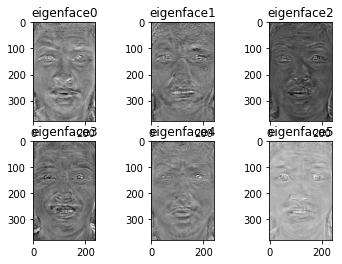

In [9]:
class Pipeline:
    
    def __init__(self, facial_expressions, dataset_dir='./CAFE/', classifier_type="logistic"):
        self.facial_expressions = facial_expressions
        if classifier_type=="logistic":
            self.classifier = LogisticClassifier()
        elif classifier_type=="softmax":
            self.classifier = SoftmaxClassifier()
        self.data_builder = DataBuilder()
        self.data_builder.load_data(data_dir)
    
    # data preprocessing
    def __pca__(self, pca_data, train, holdout, test, n_component=10):
        pca = PCA(pca_data)
        train.data = pca.transform(train.data, n_component)
        holdout.data = pca.transform(holdout.data, n_component)
        test.data = pca.transform(test.data, n_component)
        display_eigs(pca.eig_vec)
        return train, holdout, test
    
    def run(self, n_component, learning_rate, epoches):
        subjects = self.data_builder.get_subject_ids()
        
        # statistical variables
        losses = []
        accuracies = []
        
        for test_subject in subjects:
            
            # Dataset building
            train, holdout, test, pca_data = self.data_builder.build_dataset(test_subject, self.facial_expressions)
            train, holdout, test = self.__pca__(pca_data, train, holdout, test, n_component)
            
            # Run classification algorithm
            self.classifier.load_data(train, holdout, test)
            self.classifier.train(lr=learning_rate, T=epoches)
            loss, accuracy = self.classifier.test()
            losses.append(loss)
            accuracies.append(accuracy)
        
#         print(accuracies)
        return sum(losses) / len(losses), sum(accuracies) / len(accuracies)

n_components = [20, 30, 40]
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05] # 10] # 0.01 - 1

for n_component in n_components:
    for lr in learning_rates:
        pipeline = Pipeline(facial_expressions=['ht','m','s','f','a','d'], classifier_type="softmax")
        losses, accuracies = [], []
        for _ in range(10):
            loss, acc = pipeline.run(n_component=n_component, learning_rate=lr, epoches=50)
            print("loss={}, accuracy={}".format(loss, acc))
            losses.append(loss)
            accuracies.append(acc)
        print("n_component={}, learning_rates={}, loss={}, accuracy={}".format(n_component, lr, sum(losses)/len(losses), sum(accuracies)/len(accuracies)))

n_component=10, learning_rates=0.01, loss=1.6222957178112232, accuracy=0.8550000000000001
n_component=10, learning_rates=0.02, loss=2.639477216390568, accuracy=0.82
n_component=10, learning_rates=0.03, loss=4.024827276013744, accuracy=0.8299999999999998
n_component=10, learning_rates=0.04, loss=5.9757340350494825, accuracy=0.8049999999999999
n_component=10, learning_rates=0.05, loss=6.570332060662667, accuracy=0.8299999999999998
n_component=20, learning_rates=0.01, loss=1.2673635412246562, accuracy=0.8649999999999999
n_component=20, learning_rates=0.02, loss=4.356930841536387, accuracy=0.7799999999999999
n_component=20, learning_rates=0.03, loss=5.939711035841399, accuracy=0.8150000000000001
n_component=20, learning_rates=0.04, loss=6.1918835988396905, accuracy=0.7849999999999999
n_component=20, learning_rates=0.05, loss=7.760826769667512, accuracy=0.77
n_component=30, learning_rates=0.01, loss=1.8648382485697728, accuracy=0.76
n_component=30, learning_rates=0.02, loss=3.68642002598010

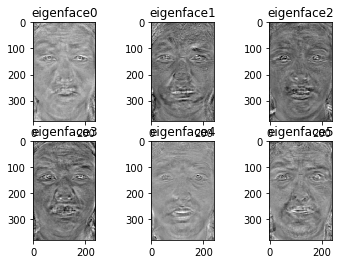

In [10]:
n_components = [10, 20, 30, 40]
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05] # 10] # Note: a good choice is between 0.01 - 1

for n_component in n_components:
    for lr in learning_rates:
        pipeline = Pipeline(facial_expressions=['ht','m'], , classifier_type="logistic")
        losses, accuracies = [], []
        for _ in range(10):
            loss, acc = pipeline.run(n_component=n_component, learning_rate=lr, epoches=10)
            losses.append(loss)
            accuracies.append(acc)
        print("n_component={}, learning_rates={}, loss={}, accuracy={}".format(n_component, lr, sum(losses)/len(losses), sum(accuracies)/len(accuracies)))